## Get a simple data set object together

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, MaxPooling2D, Activation, Concatenate, Dropout, Lambda
from keras.models import Model, Sequential
import keras
import matplotlib.pyplot as plt

In [2]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(256, 256),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(256, 256),
    batch_size = 1,
    labels = None,
)

#my_monet_ds_train = my_monet_ds_train.map(lambda x: (x / 127.5) - 1)
#my_image_ds_train = my_image_ds_train.map(lambda x: (x / 127.5) - 1)
    
DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

my_monet_ds_train = iter(my_monet_ds_train.shuffle(42).repeat())
my_image_ds_train = iter(my_image_ds_train.shuffle(42).repeat())

2025-06-15 17:07:29.371 | INFO     | cycleganstyletransfer.config:<module>:11 - PROJ_ROOT path is: C:\Users\willi\Desktop\AIPortfolio\CycleGanV2\cycleganstyletransfer


Found 1193 files belonging to 1 classes.
Using 1074 files for training.
Using 119 files for validation.
Found 7037 files belonging to 1 classes.
Using 6334 files for training.
Using 703 files for validation.


## Put the Discrim model together (With regularization)

In [3]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    
    # First layer doesn't use instance normalization
    x = Conv2D(64, 3,padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(512, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(1, 3, padding='same')(x)
    
    return Model(inputs, x, name='discriminator')

my_discriminator = build_discriminator()
my_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                     

## Generator model

In [4]:
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # One scale and bias per channel
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance per instance, per channel
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({"epsilon": self.epsilon})
        return config


In [5]:
# Reflection padding to replace zero padding
def ReflectionPad2D(pad: int):
    return Lambda(lambda x: tf.pad(x, [[0,0], [pad,pad], [pad,pad], [0,0]], mode='REFLECT'))


In [6]:

def DownSampleBlock(filters: int, kernel_size: int, strides: int):
    pad = kernel_size // 2
    block = Sequential()
    block.add(ReflectionPad2D(pad))  # prevents edge distortion
    block.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='valid'))
    block.add(InstanceNormalization())
    block.add(Activation('relu'))
    return block


In [7]:
from keras.layers import UpSampling2D, Conv2D
import uuid

def UpSampleBlock(filters: int, kernel_size: int, strides: int):
    pad = kernel_size // 2
    block = Sequential(name=f'UpsampleBlock_{uuid.uuid4()}')
    block.add(UpSampling2D(size=(strides, strides), interpolation='bilinear'))
    block.add(ReflectionPad2D(pad))  # again avoid zero padding artifacts
    block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='valid'))
    block.add(InstanceNormalization())
    block.add(Activation('relu'))
    return block

In [8]:

def Generator(input_shape: tuple, kernel_size: int = 3,
              filter_line: list[int] = [64, 128, 256, 512, 512]) -> Model:
    input_block = Input(shape=input_shape)
    x = input_block
    skips = []

    # Encoder
    for filters in filter_line:
        x = DownSampleBlock(filters, kernel_size, strides=2)(x)
        skips.append(x)

    # Decoder
    for filters, skip in zip(filter_line[::-1][1:], skips[::-1][1:]):
        x = UpSampleBlock(filters, kernel_size, strides=2)(x)
        # Ensure spatial match due to valid padding
        crop_h = (skip.shape[1] - x.shape[1]) // 2
        crop_w = (skip.shape[2] - x.shape[2]) // 2
        if crop_h > 0 or crop_w > 0:
            skip = Lambda(lambda t: t[:, crop_h:crop_h+x.shape[1], crop_w:crop_w+x.shape[2], :])(skip)
        x = Concatenate()([x, skip])

    # Final upsample
    x = UpSampleBlock(filter_line[0], kernel_size, strides=2)(x)

    # Final output layer
    pad = kernel_size // 2
    x = ReflectionPad2D(pad)(x)
    x = Conv2D(input_shape[-1], kernel_size=kernel_size, padding='valid', activation='tanh')(x)

    return Model(inputs=input_block, outputs=x)

test = Generator((128, 128, 3))
test.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 32)           960       ['input_2[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 64)           18624     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 128)          74112     ['sequential_1[0][0]']        
                                                                                              

In [9]:
my_generator = Generator((128, 128, 3))
my_generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 32)           960       ['input_3[0][0]']             
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 64)           18624     ['sequential_3[0][0]']        
                                                                                                  
 sequential_5 (Sequential)   (None, 16, 16, 128)          74112     ['sequential_4[0][0]']        
                                                                                            

In [10]:
def my_square_loss(y_true, y_pred):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), (-1, 1, 1, 1))
    y_true = tf.broadcast_to(y_true, tf.shape(y_pred))
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))


## Introducing Generator loss

In [11]:
def generator_loss(descrim_output):
        return tf.reduce_mean(tf.math.squared_difference(tf.ones_like(descrim_output), descrim_output))

## Adding Alternating trainin

In [12]:
def augment_and_normalize(image):
    image = tf.cast(image, tf.float32)  # convert from uint8
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=20)  # for 0–255 range
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = image / 127.5 - 1.0  # scale to [-1, 1]
    return image

In [13]:
def to_display(img):
    return (img[0] + 1) / 2 #* 0.5 + 0.5#tf.clip_by_value(img * 0.5 + 0.5, 0.0, 1.0)



Epoch 1/2


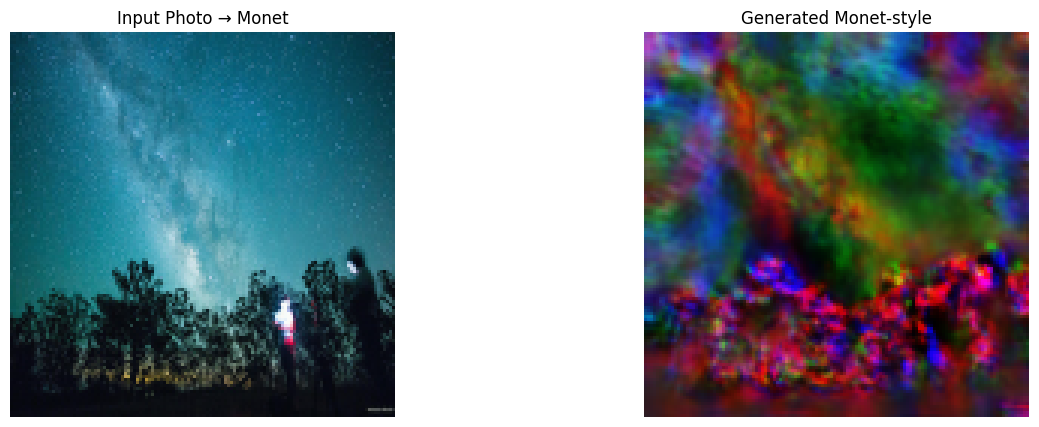

Step 100/316 - M-disc: 0.2004, P-disc: 0.2569, M-gen: 0.3435, P-gen: 0.3618, Cycle: 0.5384, Identity: 0.5353

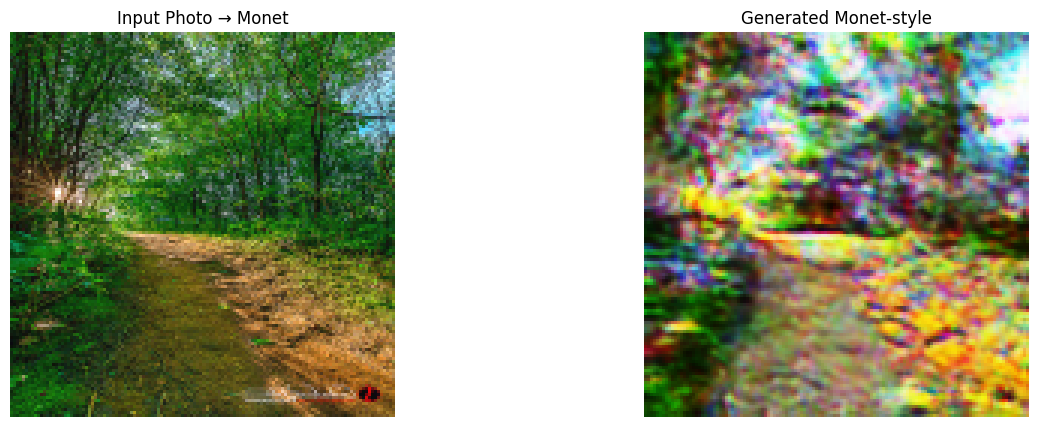

Step 200/316 - M-disc: 0.2775, P-disc: 0.2261, M-gen: 0.3813, P-gen: 0.2940, Cycle: 0.4151, Identity: 0.4333

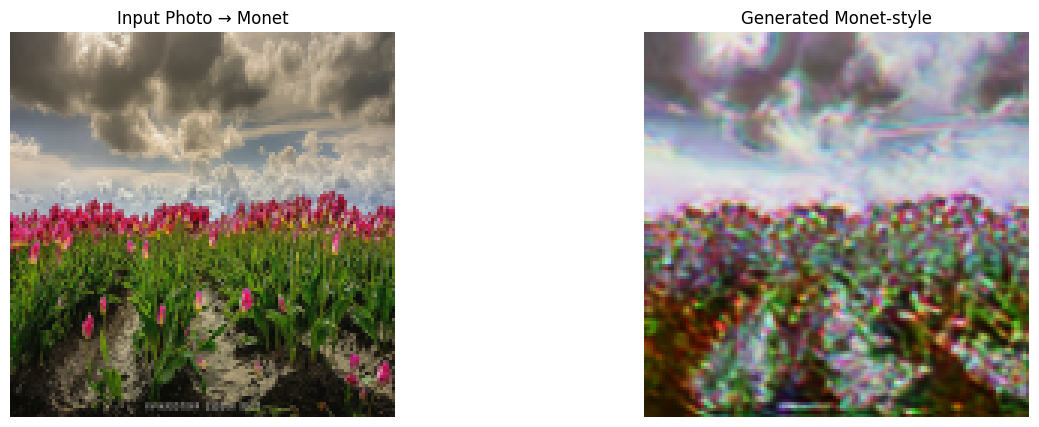

Step 300/316 - M-disc: 0.2251, P-disc: 0.2799, M-gen: 0.4212, P-gen: 0.2625, Cycle: 0.4089, Identity: 0.4087

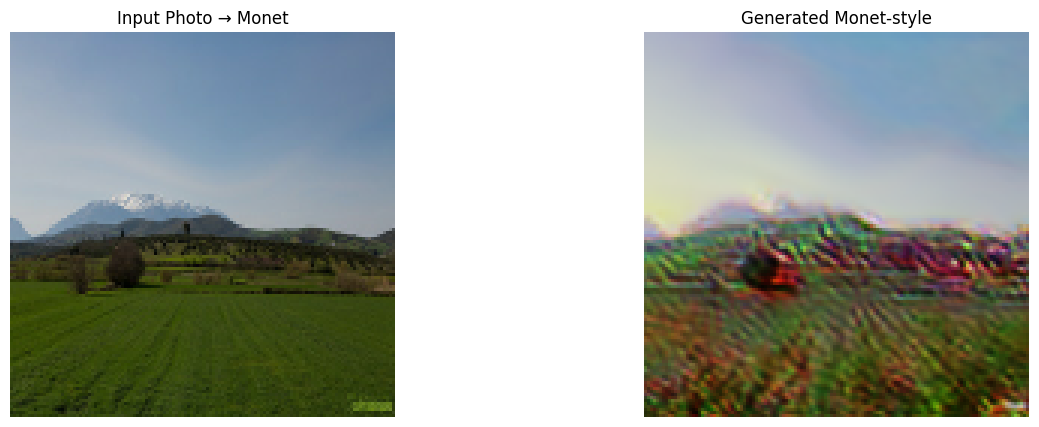

Step 316/316 - M-disc: 0.2575, P-disc: 0.2206, M-gen: 0.3006, P-gen: 0.3422, Cycle: 0.5611, Identity: 0.5882
Epoch 1 completed in 5158s - avg M-disc: 0.2812, avg P-disc: 0.2750, avg M-gen: 0.3598, avg P-gen: 0.3704, avg Cycle: 0.5977, avg Identity: 0.6088

Epoch 2/2


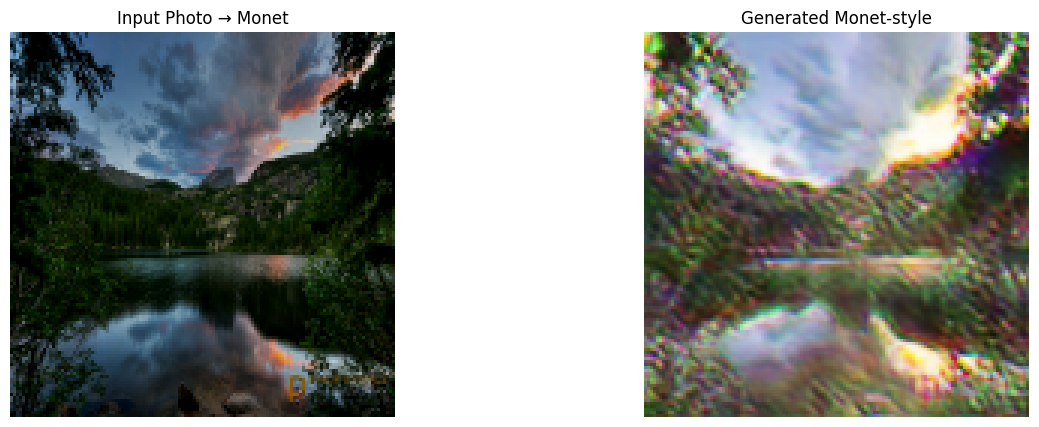

Step 100/316 - M-disc: 0.2094, P-disc: 0.2866, M-gen: 0.2928, P-gen: 0.5191, Cycle: 0.3322, Identity: 0.3433

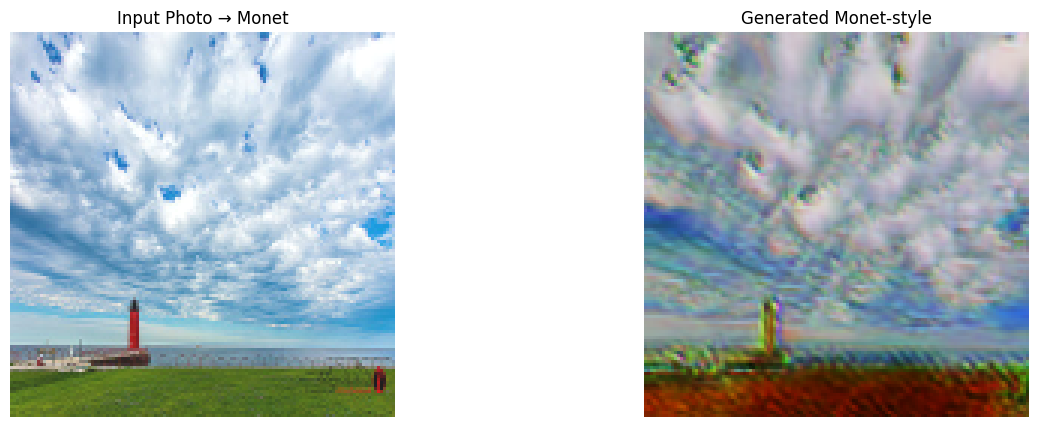

Step 200/316 - M-disc: 0.1668, P-disc: 0.1963, M-gen: 0.2758, P-gen: 0.2748, Cycle: 0.5940, Identity: 0.7292

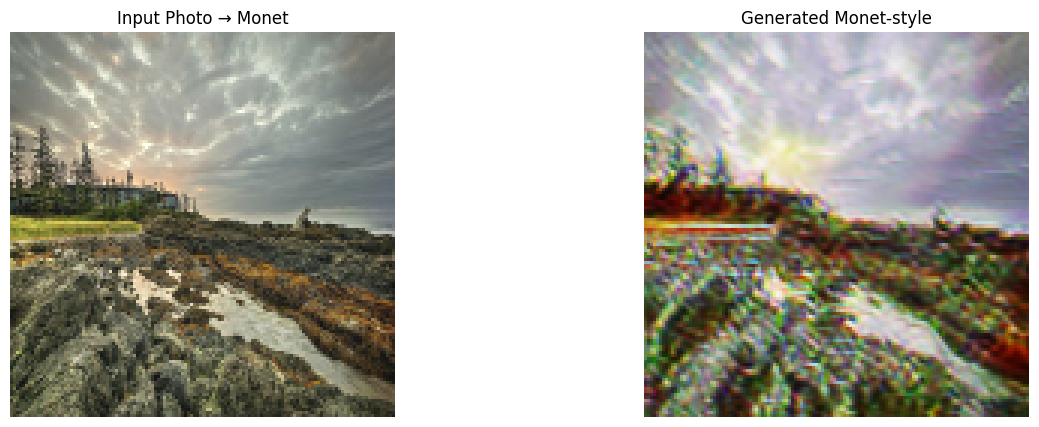

Step 300/316 - M-disc: 0.2970, P-disc: 0.2039, M-gen: 0.3329, P-gen: 0.2438, Cycle: 0.4706, Identity: 0.4569

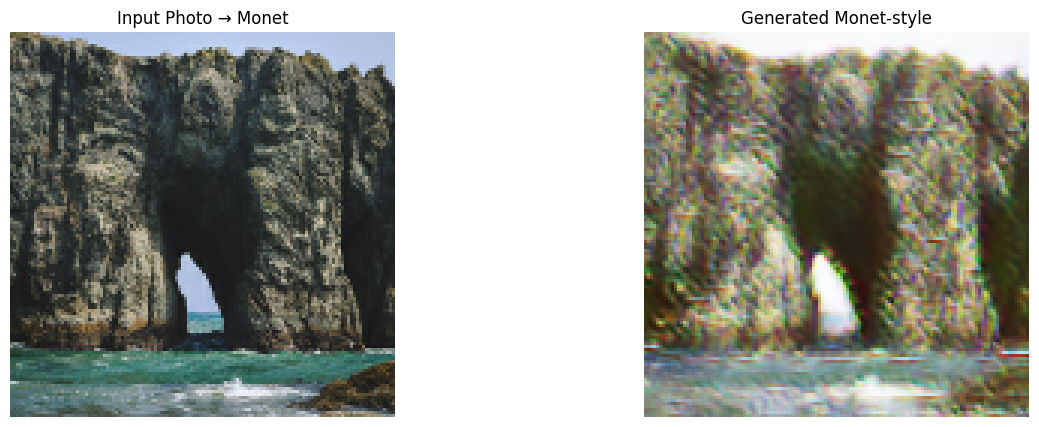

Step 316/316 - M-disc: 0.2010, P-disc: 0.2011, M-gen: 0.3007, P-gen: 0.3966, Cycle: 0.5467, Identity: 0.4552
Epoch 2 completed in 45931s - avg M-disc: 0.2421, avg P-disc: 0.2546, avg M-gen: 0.2794, avg P-gen: 0.3249, avg Cycle: 0.5439, avg Identity: 0.5384


In [26]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 20
DISPLAY_INTERVAL = 15  # record loss every 5 steps

# Optimizers for all models
monet_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
monet_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

# Initialize models
monet_generator = Generator((128, 128, 3))
photo_generator = Generator((128, 128, 3))
monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

eg_image = augment_and_normalize(next(my_image_ds_train))
eg_output = monet_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = next(my_monet_ds_train)
        photo_image = next(my_image_ds_train)
        
        # Apply random augmentation
        monet_image = augment_and_normalize(monet_image)
        photo_image = augment_and_normalize(photo_image)

        # Display progress images every 1000 steps
        if j % 100 == 0:
            test_photo_to_monet = monet_generator(photo_image)
            test_monet_to_photo = photo_generator(monet_image)
            
            plt.figure(figsize=(15, 5))

            
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(photo_image))
            plt.title('Input Photo → Monet')
            plt.axis('off')
            
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet))
            plt.title('Generated Monet-style')
            plt.axis('off')
            plt.show()
            plt.close()

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_monet = monet_generator(photo_image)
            fake_photo = photo_generator(monet_image)
            
            # Cycle consistency
            cycled_photo = photo_generator(fake_monet)
            cycled_monet = monet_generator(fake_photo)
            
            # Identity mapping
            same_monet = monet_generator(monet_image)
            same_photo = photo_generator(photo_image)

            # Discriminator outputs
            disc_real_monet = monet_discriminator(monet_image)
            disc_fake_monet = monet_discriminator(fake_monet)
            disc_real_photo = photo_discriminator(photo_image)
            disc_fake_photo = photo_discriminator(fake_photo)

            # Calculate losses
            monet_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_monet) +
                my_square_loss(tf.constant(0.0), disc_fake_monet)
            )
            photo_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_photo) +
                my_square_loss(tf.constant(0.0), disc_fake_photo)
            )

            # Generator adversarial losses
            monet_gen_loss = generator_loss(disc_fake_monet)
            photo_gen_loss = generator_loss(disc_fake_photo)

            # Cycle consistency losses
            cycle_loss = tf.reduce_mean(tf.abs(photo_image - cycled_photo)) + \
                        tf.reduce_mean(tf.abs(monet_image - cycled_monet))
            
            # Identity losses
            identity_loss = tf.reduce_mean(tf.abs(monet_image - same_monet)) + \
                          tf.reduce_mean(tf.abs(photo_image - same_photo))

            # Total generator losses
            total_monet_gen_loss = monet_gen_loss + 2 * cycle_loss + 0.5 * identity_loss
            total_photo_gen_loss = photo_gen_loss + 2 * cycle_loss + 0.5 * identity_loss

        #if j % 3 == 0:
        #   Train discriminators
        monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
        
        monet_disc_opt.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
        photo_disc_opt.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))
        #else:
        # Train generators
        monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
        
        monet_gen_opt.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
        photo_gen_opt.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            losses = (
                tf.squeeze(monet_disc_loss).numpy(),
                tf.squeeze(photo_disc_loss).numpy(),
                tf.squeeze(monet_gen_loss).numpy(),
                tf.squeeze(photo_gen_loss).numpy(),
                tf.squeeze(cycle_loss).numpy(),
                tf.squeeze(identity_loss).numpy()
            )
            epoch_losses.append(losses)
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - "
                f"M-disc: {losses[0]:.4f}, P-disc: {losses[1]:.4f}, "
                f"M-gen: {losses[2]:.4f}, P-gen: {losses[3]:.4f}, "
                f"Cycle: {losses[4]:.4f}, Identity: {losses[5]:.4f}", end='')

    # Calculate epoch averages
    epoch_avgs = np.mean(epoch_losses, axis=0)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - "
          f"avg M-disc: {epoch_avgs[0]:.4f}, avg P-disc: {epoch_avgs[1]:.4f}, "
          f"avg M-gen: {epoch_avgs[2]:.4f}, avg P-gen: {epoch_avgs[3]:.4f}, "
          f"avg Cycle: {epoch_avgs[4]:.4f}, avg Identity: {epoch_avgs[5]:.4f}")
    all_losses.extend(epoch_losses)



Epoch 1/2


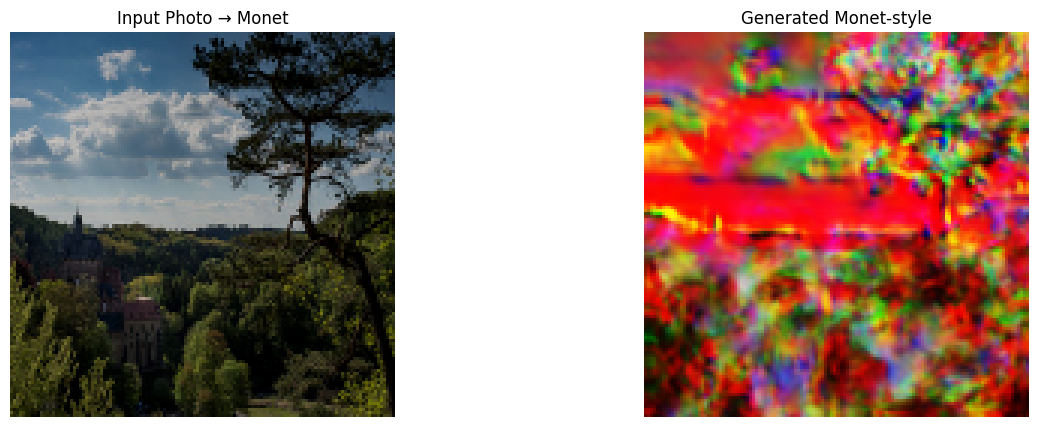

Step 100/316 - M-disc: 0.2772, P-disc: 0.2700, M-gen: 0.3001, P-gen: 0.4118, Cycle: 0.5880, Identity: 0.5551

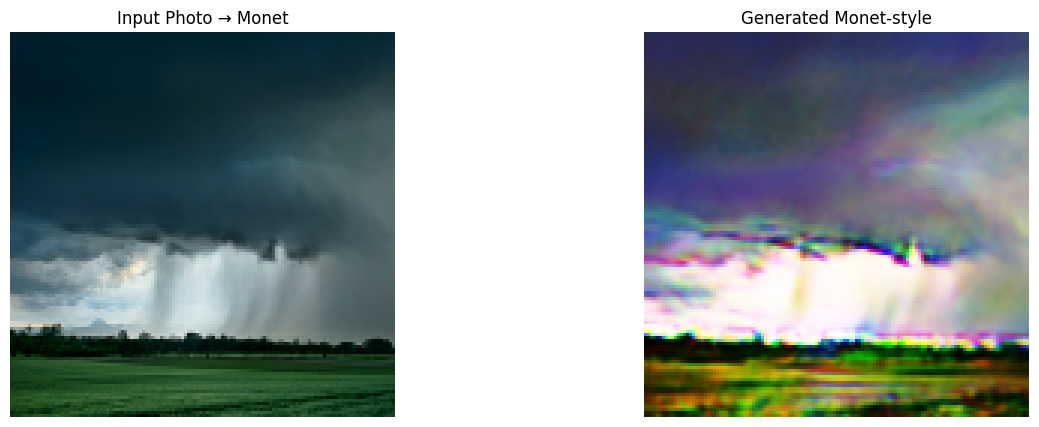

Step 200/316 - M-disc: 0.3237, P-disc: 0.2488, M-gen: 0.3770, P-gen: 0.2930, Cycle: 0.4302, Identity: 0.4387

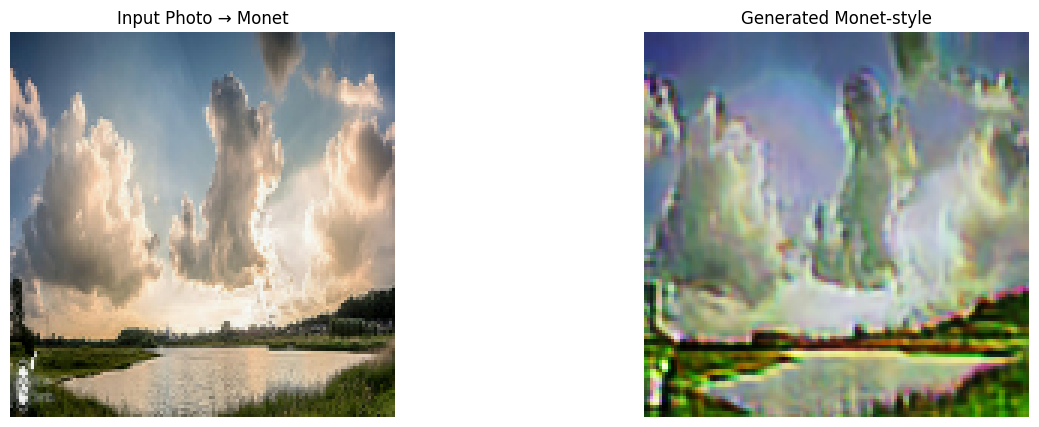

Step 300/316 - M-disc: 0.2525, P-disc: 0.2063, M-gen: 0.2427, P-gen: 0.3482, Cycle: 0.4506, Identity: 0.4761

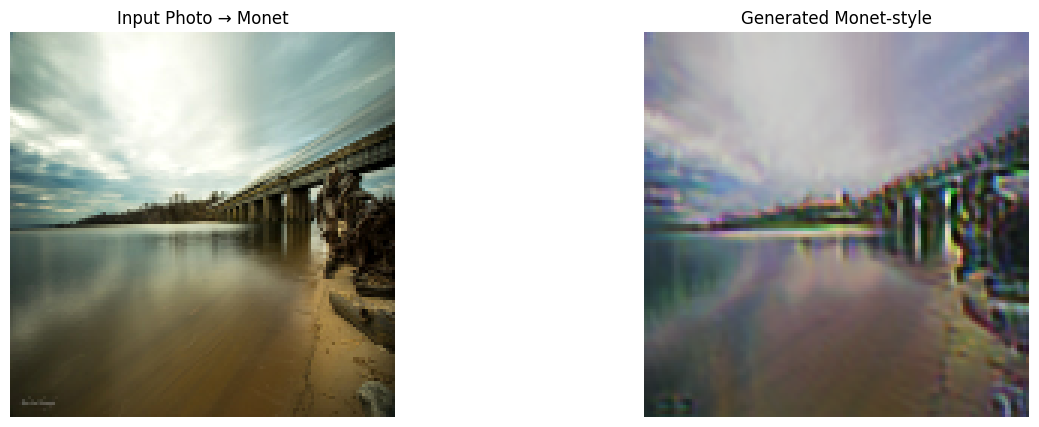

Step 316/316 - M-disc: 0.2526, P-disc: 0.2537, M-gen: 0.2846, P-gen: 0.3068, Cycle: 0.4122, Identity: 0.4088
Epoch 1 completed in 1223s - avg M-disc: 0.2648, avg P-disc: 0.2875, avg M-gen: 0.3313, avg P-gen: 0.3702, avg Cycle: 0.6388, avg Identity: 0.6404

Epoch 2/2


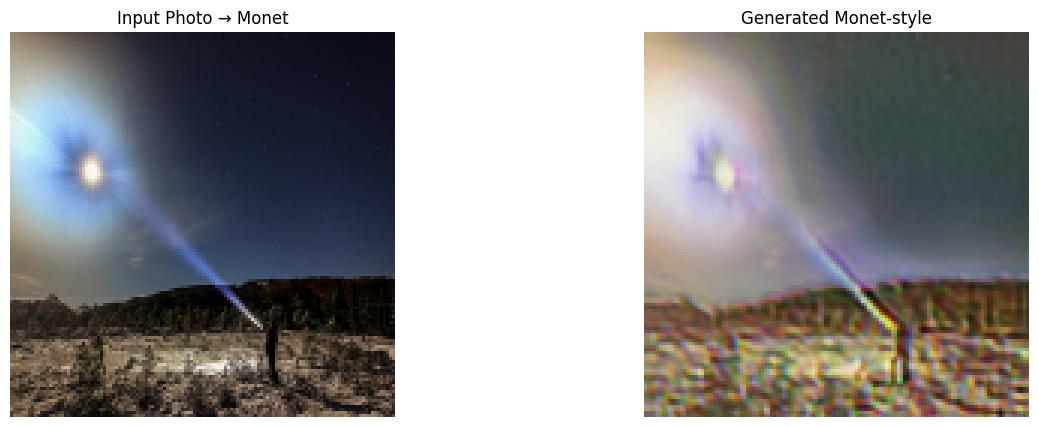

Step 100/316 - M-disc: 0.1738, P-disc: 0.2179, M-gen: 0.3236, P-gen: 0.3338, Cycle: 0.5077, Identity: 0.5266

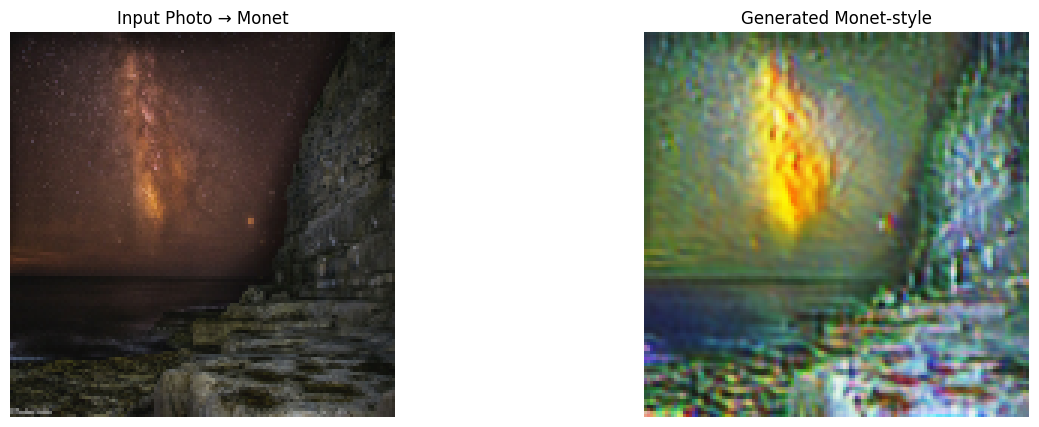

Step 200/316 - M-disc: 0.1594, P-disc: 0.2899, M-gen: 0.3801, P-gen: 0.1580, Cycle: 0.7358, Identity: 0.7458

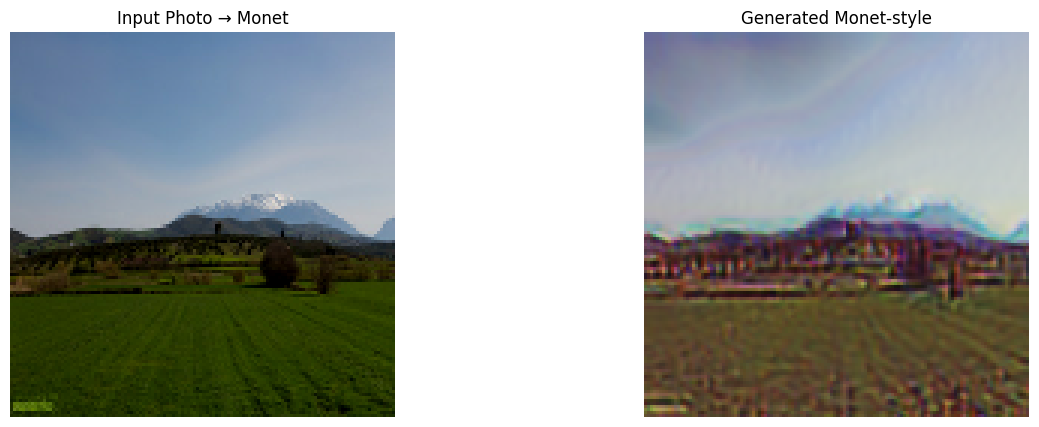

Step 300/316 - M-disc: 0.1533, P-disc: 0.2509, M-gen: 0.3635, P-gen: 0.2019, Cycle: 0.7410, Identity: 0.7780

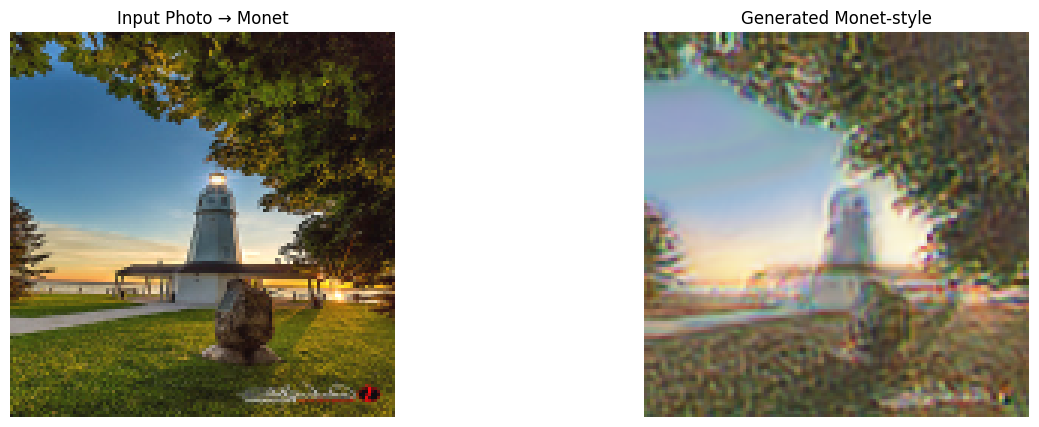

Step 316/316 - M-disc: 0.2017, P-disc: 0.1958, M-gen: 0.3134, P-gen: 0.3712, Cycle: 0.4888, Identity: 0.5054
Epoch 2 completed in 1087s - avg M-disc: 0.2022, avg P-disc: 0.2567, avg M-gen: 0.3155, avg P-gen: 0.2822, avg Cycle: 0.5376, avg Identity: 0.5338


In [16]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 20
DISPLAY_INTERVAL = 15  # record loss every 5 steps

# Optimizers for all models
monet_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
monet_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

# Initialize models
monet_generator = Generator((128, 128, 3))
photo_generator = Generator((128, 128, 3))
monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

eg_image = augment_and_normalize(next(my_image_ds_train))
eg_output = monet_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = next(my_monet_ds_train)
        photo_image = next(my_image_ds_train)
        
        # Apply random augmentation
        monet_image = augment_and_normalize(monet_image)
        photo_image = augment_and_normalize(photo_image)

        # Display progress images every 1000 steps
        if j % 100 == 0:
            test_photo_to_monet = monet_generator(photo_image)
            test_monet_to_photo = photo_generator(monet_image)
            
            plt.figure(figsize=(15, 5))

            
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(photo_image))
            plt.title('Input Photo → Monet')
            plt.axis('off')
            
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet))
            plt.title('Generated Monet-style')
            plt.axis('off')
            plt.show()
            plt.close()

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_monet = monet_generator(photo_image)
            fake_photo = photo_generator(monet_image)
            
            # Cycle consistency
            cycled_photo = photo_generator(fake_monet)
            cycled_monet = monet_generator(fake_photo)
            
            # Identity mapping
            same_monet = monet_generator(monet_image)
            same_photo = photo_generator(photo_image)

            # Discriminator outputs
            disc_real_monet = monet_discriminator(monet_image)
            disc_fake_monet = monet_discriminator(fake_monet)
            disc_real_photo = photo_discriminator(photo_image)
            disc_fake_photo = photo_discriminator(fake_photo)

            # Calculate losses
            monet_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_monet) +
                my_square_loss(tf.constant(0.0), disc_fake_monet)
            )
            photo_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_photo) +
                my_square_loss(tf.constant(0.0), disc_fake_photo)
            )

            # Generator adversarial losses
            monet_gen_loss = generator_loss(disc_fake_monet)
            photo_gen_loss = generator_loss(disc_fake_photo)

            # Cycle consistency losses
            cycle_loss = tf.reduce_mean(tf.abs(photo_image - cycled_photo)) + \
                        tf.reduce_mean(tf.abs(monet_image - cycled_monet))
            
            # Identity losses
            identity_loss = tf.reduce_mean(tf.abs(monet_image - same_monet)) + \
                          tf.reduce_mean(tf.abs(photo_image - same_photo))

            # Total generator losses
            total_monet_gen_loss = monet_gen_loss +  cycle_loss + 0.5 * identity_loss
            total_photo_gen_loss = photo_gen_loss +  cycle_loss + 0.5 * identity_loss

        #if j % 3 == 0:
        #   Train discriminators
        monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
        
        monet_disc_opt.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
        photo_disc_opt.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))
        #else:
        # Train generators
        monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
        
        monet_gen_opt.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
        photo_gen_opt.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            losses = (
                tf.squeeze(monet_disc_loss).numpy(),
                tf.squeeze(photo_disc_loss).numpy(),
                tf.squeeze(monet_gen_loss).numpy(),
                tf.squeeze(photo_gen_loss).numpy(),
                tf.squeeze(cycle_loss).numpy(),
                tf.squeeze(identity_loss).numpy()
            )
            epoch_losses.append(losses)
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - "
                f"M-disc: {losses[0]:.4f}, P-disc: {losses[1]:.4f}, "
                f"M-gen: {losses[2]:.4f}, P-gen: {losses[3]:.4f}, "
                f"Cycle: {losses[4]:.4f}, Identity: {losses[5]:.4f}", end='')

    # Calculate epoch averages
    epoch_avgs = np.mean(epoch_losses, axis=0)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - "
          f"avg M-disc: {epoch_avgs[0]:.4f}, avg P-disc: {epoch_avgs[1]:.4f}, "
          f"avg M-gen: {epoch_avgs[2]:.4f}, avg P-gen: {epoch_avgs[3]:.4f}, "
          f"avg Cycle: {epoch_avgs[4]:.4f}, avg Identity: {epoch_avgs[5]:.4f}")
    all_losses.extend(epoch_losses)



Epoch 1/3


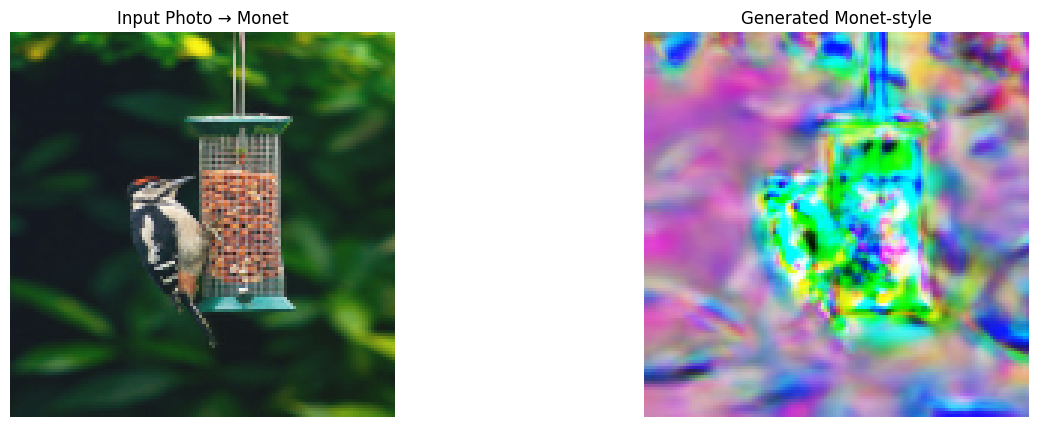

Training Discriminators
Step 1/5 - M-disc: 0.6476, P-disc: 0.7434, M-gen: 1.3238, P-gen: 1.4364, Cycle: 1.5451, Identity: 1.6917Training Discriminators
Step 2/5 - M-disc: 0.6476, P-disc: 0.7434, M-gen: 1.3238, P-gen: 1.4364, Cycle: 1.5451, Identity: 1.6917Training Discriminators
Step 3/5 - M-disc: 0.6476, P-disc: 0.7434, M-gen: 1.3238, P-gen: 1.4364, Cycle: 1.5451, Identity: 1.6917Training Discriminators
Step 4/5 - M-disc: 0.6476, P-disc: 0.7434, M-gen: 1.3238, P-gen: 1.4364, Cycle: 1.5451, Identity: 1.6917Training Discriminators
Step 5/5 - M-disc: 0.6476, P-disc: 0.7434, M-gen: 1.3238, P-gen: 1.4364, Cycle: 1.5451, Identity: 1.6917
Epoch 1 completed in 17s - avg M-disc: 0.6476, avg P-disc: 0.7434, avg M-gen: 1.3238, avg P-gen: 1.4364, avg Cycle: 1.5451, avg Identity: 1.6917

Epoch 2/3


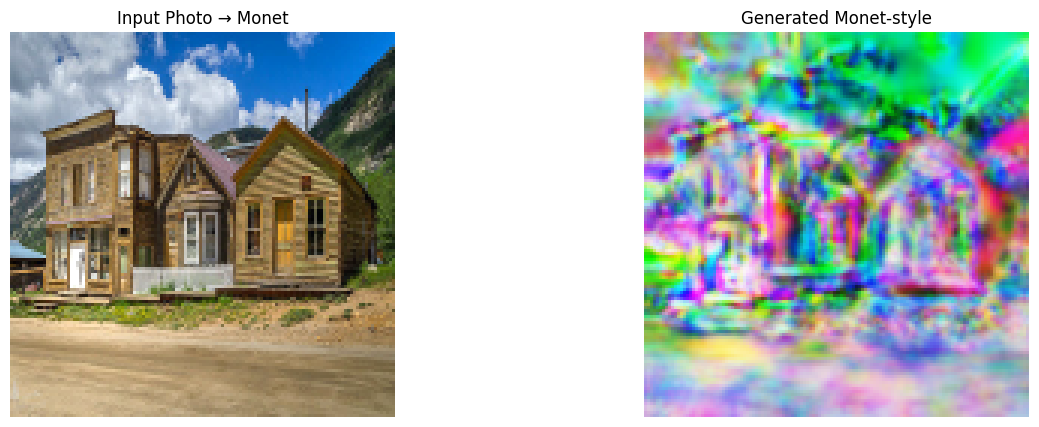

Training Discriminators
Step 2/5 - M-disc: 0.4294, P-disc: 0.5244, M-gen: 0.7824, P-gen: 1.0193, Cycle: 1.0176, Identity: 1.1216Training Discriminators
Step 4/5 - M-disc: 0.4294, P-disc: 0.5244, M-gen: 0.7824, P-gen: 1.0193, Cycle: 1.0176, Identity: 1.1216Training Discriminators
Step 5/5 - M-disc: 0.4294, P-disc: 0.5244, M-gen: 0.7824, P-gen: 1.0193, Cycle: 1.0176, Identity: 1.1216
Epoch 2 completed in 15s - avg M-disc: 0.4294, avg P-disc: 0.5244, avg M-gen: 0.7824, avg P-gen: 1.0193, avg Cycle: 1.0176, avg Identity: 1.1216

Epoch 3/3


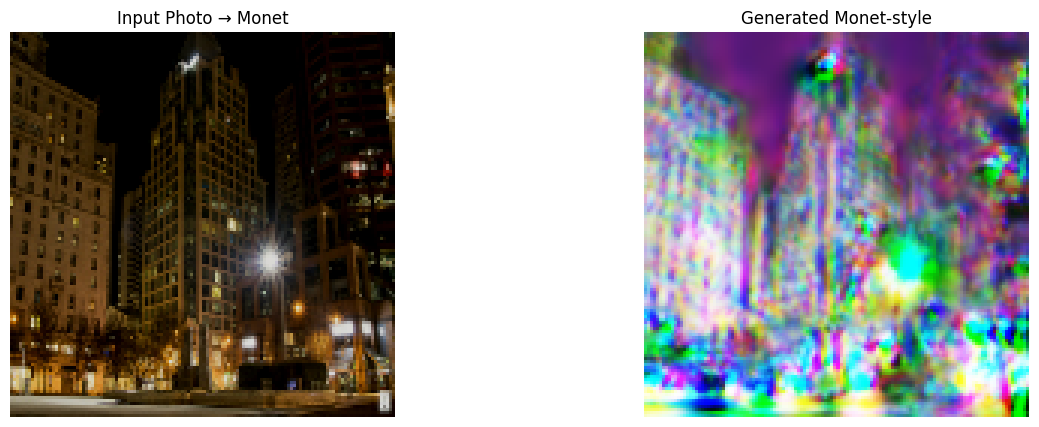

Training Discriminators
Step 2/5 - M-disc: 0.4082, P-disc: 0.2968, M-gen: 0.5895, P-gen: 0.8290, Cycle: 1.3695, Identity: 1.4140Training Discriminators
Step 4/5 - M-disc: 0.4082, P-disc: 0.2968, M-gen: 0.5895, P-gen: 0.8290, Cycle: 1.3695, Identity: 1.4140Training Discriminators
Step 5/5 - M-disc: 0.4082, P-disc: 0.2968, M-gen: 0.5895, P-gen: 0.8290, Cycle: 1.3695, Identity: 1.4140
Epoch 3 completed in 15s - avg M-disc: 0.4082, avg P-disc: 0.2968, avg M-gen: 0.5895, avg P-gen: 0.8290, avg Cycle: 1.3695, avg Identity: 1.4140


In [14]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 3
EPOCH_LENGTH = 5# DATASET_HEIGHT // 20
DISPLAY_INTERVAL = 15  # record loss every 5 steps

# Optimizers for all models
monet_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
monet_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

# Initialize models
monet_generator = Generator((128, 128, 3))
photo_generator = Generator((128, 128, 3))
monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

eg_image = augment_and_normalize(next(my_image_ds_train))
eg_output = monet_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = next(my_monet_ds_train)
        photo_image = next(my_image_ds_train)
        
        # Apply random augmentation
        monet_image = augment_and_normalize(monet_image)
        photo_image = augment_and_normalize(photo_image)

        # Display progress images every 1000 steps
        if j % 100 == 0:
            test_photo_to_monet = monet_generator(photo_image)
            test_monet_to_photo = photo_generator(monet_image)
            
            plt.figure(figsize=(15, 5))

            
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(photo_image))
            plt.title('Input Photo → Monet')
            plt.axis('off')
            
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet))
            plt.title('Generated Monet-style')
            plt.axis('off')
            plt.show()
            plt.close()

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_monet = monet_generator(photo_image)
            fake_photo = photo_generator(monet_image)
            
            # Cycle consistency
            cycled_photo = photo_generator(fake_monet)
            cycled_monet = monet_generator(fake_photo)
            
            # Identity mapping
            same_monet = monet_generator(monet_image)
            same_photo = photo_generator(photo_image)

            # Discriminator outputs
            disc_real_monet = monet_discriminator(monet_image)
            disc_fake_monet = monet_discriminator(fake_monet)
            disc_real_photo = photo_discriminator(photo_image)
            disc_fake_photo = photo_discriminator(fake_photo)

            # Calculate losses
            monet_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_monet) +
                my_square_loss(tf.constant(0.0), disc_fake_monet)
            )
            photo_disc_loss = 0.5 * (
                my_square_loss(tf.constant(1.0), disc_real_photo) +
                my_square_loss(tf.constant(0.0), disc_fake_photo)
            )

            # Generator adversarial losses
            monet_gen_loss = generator_loss(disc_fake_monet)
            photo_gen_loss = generator_loss(disc_fake_photo)

            # Cycle consistency losses
            cycle_loss = tf.reduce_mean(tf.abs(photo_image - cycled_photo)) + \
                        tf.reduce_mean(tf.abs(monet_image - cycled_monet))
            
            # Identity losses
            identity_loss = tf.reduce_mean(tf.abs(monet_image - same_monet)) + \
                          tf.reduce_mean(tf.abs(photo_image - same_photo))

            # Total generator losses
            total_monet_gen_loss = monet_gen_loss +  cycle_loss + 0.5 * identity_loss
            total_photo_gen_loss = photo_gen_loss +  cycle_loss + 0.5 * identity_loss

        if j % 2 == 0 or i==0:
            print("Training Discriminators")
            #   Train discriminators
            monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
            photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
            
            monet_disc_opt.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
            photo_disc_opt.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))
        #else:
        # Train generators
        monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
        
        monet_gen_opt.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
        photo_gen_opt.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            losses = (
                tf.squeeze(monet_disc_loss).numpy(),
                tf.squeeze(photo_disc_loss).numpy(),
                tf.squeeze(monet_gen_loss).numpy(),
                tf.squeeze(photo_gen_loss).numpy(),
                tf.squeeze(cycle_loss).numpy(),
                tf.squeeze(identity_loss).numpy()
            )
            epoch_losses.append(losses)
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - "
                f"M-disc: {losses[0]:.4f}, P-disc: {losses[1]:.4f}, "
                f"M-gen: {losses[2]:.4f}, P-gen: {losses[3]:.4f}, "
                f"Cycle: {losses[4]:.4f}, Identity: {losses[5]:.4f}", end='')

    # Calculate epoch averages
    epoch_avgs = np.mean(epoch_losses, axis=0)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - "
          f"avg M-disc: {epoch_avgs[0]:.4f}, avg P-disc: {epoch_avgs[1]:.4f}, "
          f"avg M-gen: {epoch_avgs[2]:.4f}, avg P-gen: {epoch_avgs[3]:.4f}, "
          f"avg Cycle: {epoch_avgs[4]:.4f}, avg Identity: {epoch_avgs[5]:.4f}")
    all_losses.extend(epoch_losses)
